In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def f(txt,mapping):
    return [mapping[key] for key in txt] 
soft = torch.nn.Softmax(dim=1)

## Exam4: AbAcAd (3)

In [18]:
txt = list('AbAcAd')*100

In [19]:
txt_x = txt[:-1]
txt_y = txt[1:]

In [20]:
x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'A':0,'b':1,'c':2,'d':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'A':0,'b':1,'c':2,'d':3}))).float()

### 순환신경망 구현2 (with RNNCell, hidden node 2) -- 성공 (복습)

`(1)` 숙성네트워크

In [24]:
torch.manual_seed(43052)
rnncell = torch.nn.RNNCell(4,2) # x:(n,4) , h:(n,2) 

`(2)` 조리네트워크

In [25]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) # 숙성된 2차원의 단어를 다시 4차원으로 바꿔줘야지 나중에 softmax 취할 수 있음

`(3)` 손실함수와 옵티마이저 

In [26]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnncell.parameters())+list(cook.parameters()))

`(4)` 학습

In [27]:
T = len(x) 
for epoc in range(5000):
    ## 1~2
    loss = 0 
    ht = torch.zeros(1,2) 
    for t in range(T):
        xt,yt = x[[t]], y[[t]]
        ht = rnncell(xt,ht)
        ot = cook(ht)
        loss = loss + loss_fn(ot,yt) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화 

In [28]:
hidden = torch.zeros(T,2) 

In [29]:
# t=0 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
# t=1~T 
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])

In [30]:
yhat = soft(cook(hidden))
yhat

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7702e-02, 1.3384e-02],
        [2.0031e-02, 1.0660e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

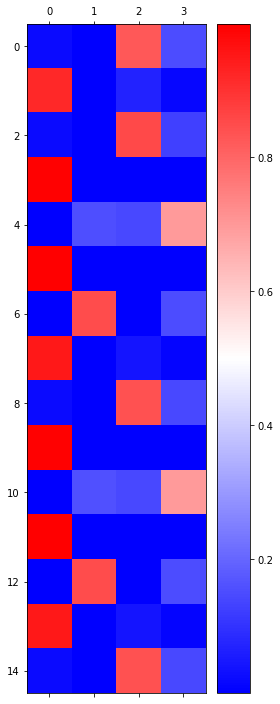

In [33]:
plt.matshow(yhat[:15].data,cmap='bwr')
plt.colorbar()
# 처음부터 15개

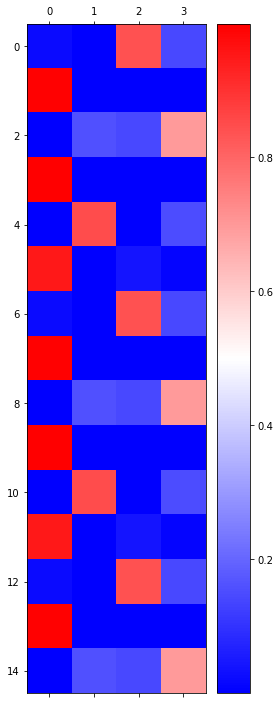

In [34]:
plt.matshow(yhat[-15:].data,cmap='bwr')
plt.colorbar()
# 마지막 15개

### 순환신경망 구현3 (with RNN, hidden node 2) -- 성공 

(예비학습)

`-` 네트워크학습이후 yhat을 구하려면 번거로웠음 

```Python
hidden = torch.zeros(T,2) 
_water = torch.zeros(1,2)
hidden[[0]] = rnncell(x[[0]],_water)
for t in range(1,T):
    hidden[[t]] = rnncell(x[[t]],hidden[[t-1]])
yhat = soft(cook(hidden))
```

`-` 이렇게 하면 쉽게(?) 구할 수 있음 

In [35]:
rnn = torch.nn.RNN(4,2)

In [36]:
rnn.weight_hh_l0.data = rnncell.weight_hh.data 
rnn.weight_ih_l0.data = rnncell.weight_ih.data
rnn.bias_hh_l0.data = rnncell.bias_hh.data
rnn.bias_ih_l0.data = rnncell.bias_ih.data

`-` rnn(x,_water)의 결과는 (1) 599년치 간장 (2) 599번째 간장 이다 

In [37]:
rnn(x,_water)

(tensor([[-0.9912, -0.9117],
         [ 0.0698, -1.0000],
         [-0.9927, -0.9682],
         ...,
         [-0.9935, -0.9315],
         [ 0.5777, -1.0000],
         [-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.9960, -0.0109]], grad_fn=<SqueezeBackward1>))

In [39]:
hidden

tensor([[-0.9912, -0.9117],
        [ 0.0698, -1.0000],
        [-0.9927, -0.9682],
        ...,
        [-0.9935, -0.9315],
        [ 0.5777, -1.0000],
        [-0.9960, -0.0109]], grad_fn=<IndexPutBackward0>)

In [ ]:
soft(cook(rnn(x,_water)[0]))

tensor([[1.9725e-02, 1.5469e-03, 8.2766e-01, 1.5106e-01],
        [9.1875e-01, 1.6513e-04, 6.7702e-02, 1.3384e-02],
        [2.0031e-02, 1.0660e-03, 8.5248e-01, 1.2642e-01],
        ...,
        [1.9640e-02, 1.3568e-03, 8.3705e-01, 1.4196e-01],
        [9.9564e-01, 1.3114e-05, 3.5069e-03, 8.4108e-04],
        [3.5473e-03, 1.5670e-01, 1.4102e-01, 6.9873e-01]],
       grad_fn=<SoftmaxBackward0>)

***(예비학습결론) torch.nn.RNN(4,2)는 torch.nn.RNNCell(4,2)의 batch 버전이다. (for문이 포함된 버전이다)***

---

torch.nn.RNN(4,2)를 이용하여 구현하자. 

`(1)` 숙성네트워크

선언

In [ ]:
rnn = torch.nn.RNN(4,2)

가중치초기화

In [ ]:
torch.manual_seed(43052)
_rnncell = torch.nn.RNNCell(4,2)

In [ ]:
rnn.weight_hh_l0.data = _rnncell.weight_hh.data 
rnn.weight_ih_l0.data = _rnncell.weight_ih.data
rnn.bias_hh_l0.data = _rnncell.bias_hh.data
rnn.bias_ih_l0.data = _rnncell.bias_ih.data

`(2)` 조리네트워크

In [ ]:
torch.manual_seed(43052)
cook = torch.nn.Linear(2,4) 

`(3)` 손실함수와 옵티마이저

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
_water = torch.zeros(1,2) 
for epoc in range(5000):
    ## 1 
    hidden,hT = rnn(x,_water)
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [ ]:
yhat = soft(output)

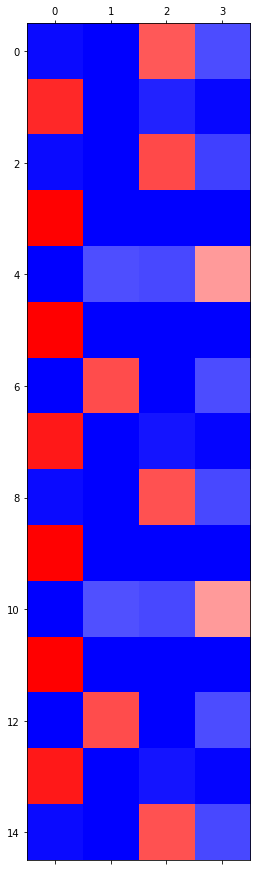

In [ ]:
plt.matshow(yhat.data[:15],cmap='bwr')

- 처음은 좀 틀렸음 ㅎㅎ

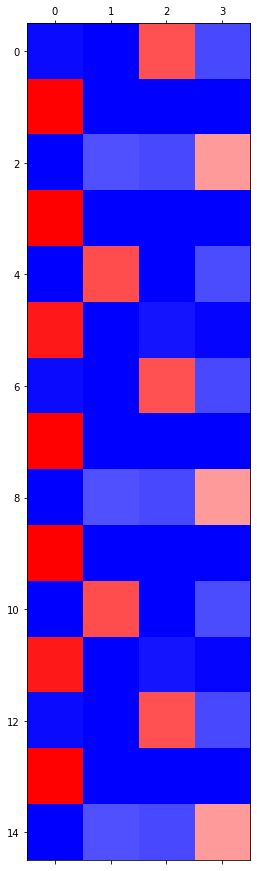

In [ ]:
plt.matshow(yhat.data[-15:],cmap='bwr')

- 뒤에는 잘맞음 

**실전팁: `_water` 대신에 `hT`를 대입 (사실 큰 차이는 없음)**

In [ ]:
rnn(x[:6],_water),rnn(x[:6],hT)

((tensor([[-0.9912, -0.9117],
          [ 0.0698, -1.0000],
          [-0.9927, -0.9682],
          [ 0.5761, -1.0000],
          [-0.9960, -0.0173],
          [ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>)),
 (tensor([[-0.9713, -1.0000],
          [ 0.0535, -1.0000],
          [-0.9925, -0.9720],
          [ 0.5759, -1.0000],
          [-0.9960, -0.0180],
          [ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>),
  tensor([[ 0.9960, -1.0000]], grad_fn=<SqueezeBackward1>)))

`(6)` 시각화2: hidden, yhat

In [ ]:
combinded = torch.concat([hidden,yhat],axis=1)

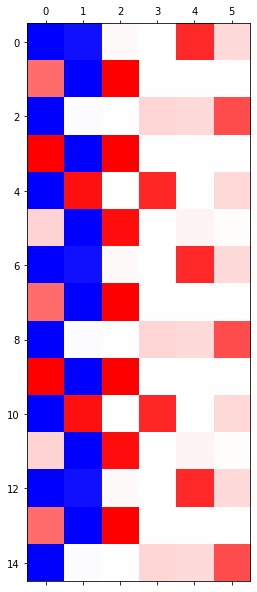

In [ ]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 히든노드의 해석이 어려움. 

### 순환신경망 구현4 (with RNN, hidden node 3) -- 성공 

`(1)` 숙성네트워크~ `(2)` 조리네트워크

In [ ]:
torch.manual_seed(2) #1 
rnn = torch.nn.RNN(4,3) #hidden node : 3
cook = torch.nn.Linear(3,4) 

`(3)` 손실함수와 옵티마이저

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [ ]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) 
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [ ]:
yhat = soft(output)

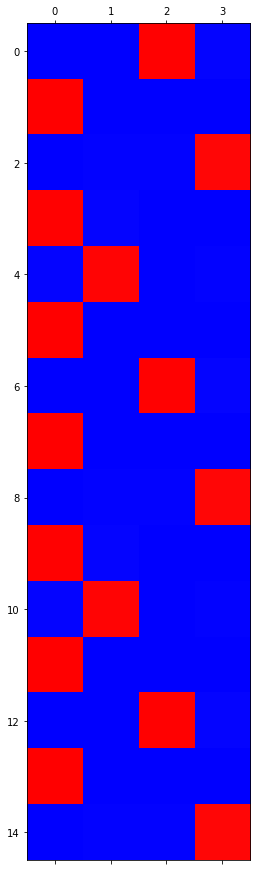

In [ ]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden, yhat

In [ ]:
combinded = torch.concat([hidden,yhat],axis=1)

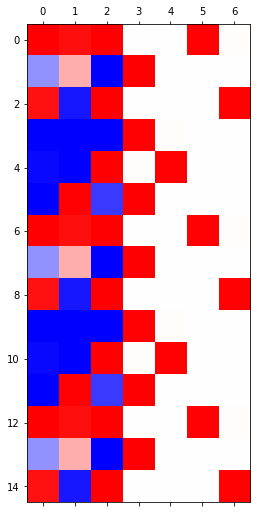

In [ ]:
plt.matshow(combinded[-15:].data,cmap='bwr')

- 세번째 히든노드 = 대소문자를 구분
- 1,2 히든노드 = bcd를 구분 

## HW: hello 예제

아래와 같이 hello가 반복되는 자료가 있다고 하자. 

In [8]:
txt = list('hello')*100

txt_x = txt[:-1]
txt_y = txt[1:]

x = torch.nn.functional.one_hot(torch.tensor(f(txt_x,{'h':0,'e':1,'l':2,'o':3}))).float()
y = torch.nn.functional.one_hot(torch.tensor(f(txt_y,{'h':0,'e':1,'l':2,'o':3}))).float()

In [9]:
rnn = torch.nn.RNN(4,3) 
cook = torch.nn.Linear(3,4)

`(3)` 손실함수와 옵티마이저

In [10]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(list(rnn.parameters())+list(cook.parameters()))

`(4)` 학습

In [11]:
_water = torch.zeros(1,3) 
for epoc in range(5000):
    ## 1
    hidden,hT = rnn(x,_water) 
    output = cook(hidden) 
    ## 2 
    loss = loss_fn(output,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`(5)` 시각화1: yhat

In [12]:
yhat = soft(output)

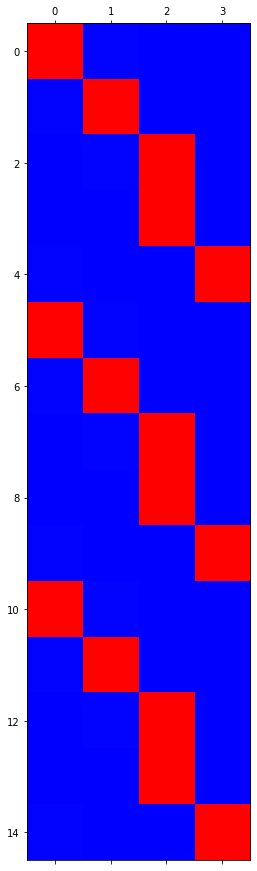

In [13]:
plt.matshow(yhat[-15:].data,cmap='bwr')

`(6)` 시각화2: hidden, yhat

In [14]:
combinded = torch.concat([hidden,yhat],axis=1)

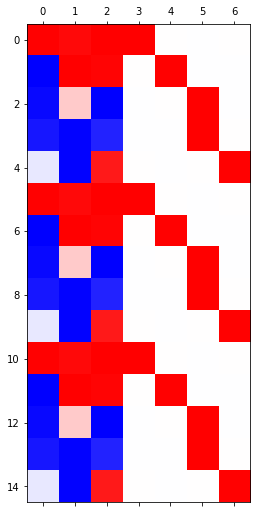

In [15]:
plt.matshow(combinded[-15:].data,cmap='bwr')